In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import zipfile

# 1) Loading the data

In [2]:
DATA_PATH = '/home/victor/Aero_TFG/Data'
    
OUT_PATH = '/home/victor/Aero_TFG/analysedData/'

In [3]:
dfs = []
for dirname, dirs, files in os.walk(DATA_PATH):
    for d in dirs:
        filename = os.listdir(os.path.join(dirname, d))[0]
        full_path = os.path.join(dirname, d, filename)
        df_aux = pd.read_csv(full_path)
        # log.write("{}: {} flights read\n".format(d, str(len(df_aux.index))))
        dfs.append(df_aux)
df = pd.concat(dfs)
dfs.clear()
print('DONE - Entries read: ' + str(len(df.index)), flush=True)
df = df[['ARR_DELAY', 'ARR_TIME', 'CRS_ARR_TIME', 'CRS_DEP_TIME', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'DEP_TIME', 'DEST', 'FL_DATE', 'MONTH', 'ORIGIN', 'QUARTER', 'YEAR']]

ValueError: No objects to concatenate

In [ ]:
df.shape

In [ ]:
df.head(5)

In [ ]:
df.isnull().sum()
# Cancelled flights

In [ ]:
df = df.dropna()
df.shape

In [ ]:
df.memory_usage().sum()/(1024*1024)

In [ ]:
for c in df.columns:
    if 'float' in str(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='float')
    elif 'int' in str(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='integer')

In [ ]:
df.memory_usage().sum()/(1024*1024)

# 2.2) Filtering OD pairs with less than 10 flights per day

In [ ]:
df['OD_PAIR'] = df['ORIGIN'] + '_' + df['DEST']

In [ ]:
gb_odpair = pd.DataFrame(df.groupby(['ORIGIN','DEST','OD_PAIR'])['ARR_DELAY'].count()).reset_index(drop=False)
gb_odpair.columns = ['ORIGIN', 'DEST', 'OD_PAIR', 'COUNT']

n_dates = df['FL_DATE'].unique().shape[0]
gb_cons = gb_odpair.loc[gb_odpair['COUNT'] >= 10*n_dates]
od_pairs = gb_cons['OD_PAIR'].tolist()

airports = (pd.concat([gb_cons['ORIGIN'], gb_cons['DEST']])).unique().tolist()

print("Number of days in the analysis: ", n_dates)
print("Original number of airports: ", pd.concat([df['ORIGIN'], df['DEST']]).unique().shape[0])
print("Number of airports after filtering: ", len(airports))
print("Orignal number of OD pairs: ", df['OD_PAIR'].unique().shape[0])
print("Number of OD pairs after filtering", len(od_pairs))

In [ ]:
df_filtered = df[df['OD_PAIR'].isin(od_pairs)].reset_index(drop=True)

In [ ]:
df_filtered.shape

In [ ]:
# Calculating 100 most delayed OD_PAIRS
gb_odpairs_meandel = (df_filtered.groupby('OD_PAIR')['DEP_DELAY']).agg('mean').sort_values(ascending=False)
print(gb_odpairs_meandel.head())
most_delayed_pairs = list(gb_odpairs_meandel.index[0:100])
most_delayed_pairs[0:5]

# 3) Modifying data columns

In [ ]:
df_filtered['CRS_ARR_HOUR'] = df_filtered['CRS_ARR_TIME'].apply(lambda x: int(x//100)).apply(lambda x: 0 if x == 24 else x)
df_filtered['CRS_DEP_HOUR'] = df_filtered['CRS_DEP_TIME'].apply(lambda x: int(x//100)).apply(lambda x: 0 if x == 24 else x)

df_filtered['ARR_HOUR'] = df_filtered['ARR_TIME'].apply(lambda x: int(x//100)).apply(lambda x: 0 if x == 24 else x)
df_filtered['DEP_HOUR'] = df_filtered['DEP_TIME'].apply(lambda x: int(x//100)).apply(lambda x: 0 if x == 24 else x)

# 4) Defining the graph

In [ ]:
nodes = np.array(sorted(airports))
od_pairs = np.array(sorted(od_pairs))

In [ ]:
A = np.zeros([od_pairs.shape[0], od_pairs.shape[0]])
A_w = np.zeros([od_pairs.shape[0], od_pairs.shape[0]])

for i, od_i in enumerate(od_pairs):
    for j, od_j in enumerate(od_pairs):
        if od_i.split('_')[0] == od_j.split('_')[0] or\
           od_i.split('_')[0] == od_j.split('_')[1] or\
           od_i.split('_')[1] == od_j.split('_')[0] or\
           od_i.split('_')[1] == od_j.split('_')[1]:
            
            A[i, j] = 1

In [ ]:
D = np.diag((A.T@A).diagonal())
L = D - A

# 5) Creating the signal

## Median delay for OD Pairs

In [ ]:
df_dep_delay = pd.DataFrame(df_filtered.groupby(['FL_DATE', 'CRS_DEP_HOUR', 'OD_PAIR'])['DEP_DELAY'].agg(list))
df_arr_delay = pd.DataFrame(df_filtered.groupby(['FL_DATE', 'CRS_ARR_HOUR', 'OD_PAIR'])['ARR_DELAY'].agg(list))

df_dep_delay = df_dep_delay.reset_index(drop=False)
df_arr_delay = df_arr_delay.reset_index(drop=False)

df_dep_delay.columns = ['FL_DATE', 'HOUR', 'OD_PAIR', 'DEP_DELAY']
df_arr_delay.columns = ['FL_DATE', 'HOUR', 'OD_PAIR', 'ARR_DELAY']

In [ ]:
df_merged = df_dep_delay.merge(df_arr_delay,
                                  how='outer',
                                  on=['FL_DATE', 'HOUR', 'OD_PAIR'])

df_merged['ARR_DELAY'] = df_merged['ARR_DELAY'].apply(lambda x: x if type(x) == list else [])
df_merged['DEP_DELAY'] = df_merged['DEP_DELAY'].apply(lambda x: x if type(x) == list else [])

# Add the t-1 hour flights to make it a window of size 2 hours
arr_delay_tm1 = df_merged['ARR_DELAY'].shift(od_pairs.shape[0]).apply(lambda x: x if type(x) == list else [])
dep_delay_tm1 = df_merged['DEP_DELAY'].shift(od_pairs.shape[0]).apply(lambda x: x if type(x) == list else [])

df_merged['ARR_DELAY'] = df_merged['ARR_DELAY'] + arr_delay_tm1
df_merged['DEP_DELAY'] = df_merged['DEP_DELAY'] + dep_delay_tm1

In [ ]:
df_merged['MEDIAN_ARR_DELAY'] = df_merged['ARR_DELAY'].apply(np.median)
df_merged['MEDIAN_DEP_DELAY'] = df_merged["DEP_DELAY"].apply(np.median)

#df_merged['MEAN_ARR_DELAY'] = df_merged['ARR_DELAY'].apply(np.mean)
#df_merged['MEAN_DEP_DELAY'] = df_merged["DEP_DELAY"].apply(np.mean)

df_merged['FL_DATE'] = pd.to_datetime(df_merged['FL_DATE'])

In [ ]:
df_merged.head()

## Median Delay for Airports

In [ ]:
df_origin_delay = pd.DataFrame(df_filtered.groupby(['FL_DATE', 'CRS_DEP_HOUR', 'ORIGIN'])['DEP_DELAY'].agg(list))
df_arr_delay = pd.DataFrame(df_filtered.groupby(['FL_DATE', 'CRS_ARR_HOUR', 'DEST'])['ARR_DELAY'].agg(list))

df_origin_delay = df_origin_delay.reset_index(drop=False)
df_arr_delay = df_arr_delay.reset_index(drop=False)

df_origin_delay.columns = ['FL_DATE', 'HOUR', 'NODE', 'DEP_DELAY']
df_arr_delay.columns = ['FL_DATE', 'HOUR', 'NODE', 'ARR_DELAY']

In [ ]:
df_merged_node = df_origin_delay.merge(df_arr_delay,
                                  how='outer',
                                  on=['FL_DATE', 'HOUR', 'NODE'])

df_merged_node['ARR_DELAY'] = df_merged['ARR_DELAY'].apply(lambda x: x if type(x) == list else [])
df_merged_node['DEP_DELAY'] = df_merged['DEP_DELAY'].apply(lambda x: x if type(x) == list else [])

# Add the t-1 hour flights to make it a window of size 2 hours
arr_delay_tm1 = df_merged_node['ARR_DELAY'].shift(nodes.shape[0]).apply(lambda x: x if type(x) == list else [])
dep_delay_tm1 = df_merged_node['DEP_DELAY'].shift(nodes.shape[0]).apply(lambda x: x if type(x) == list else [])

df_merged_node['ARR_DELAY'] = df_merged_node['ARR_DELAY'] + arr_delay_tm1
df_merged_node['DEP_DELAY'] = df_merged_node['DEP_DELAY'] + dep_delay_tm1

df_merged_node['MEDIAN_NODE_DELAY'] = (df_merged_node["DEP_DELAY"] + df_merged_node["ARR_DELAY"]).apply(np.median)
df_merged_node['MEDIAN_NODE_DEP_DELAY'] = df_merged_node['DEP_DELAY'].apply(np.median)
df_merged_node['MEDIAN_NODE_ARR_DELAY'] = df_merged_node['ARR_DELAY'].apply(np.median)
df_merged_node['FL_DATE'] = pd.to_datetime(df_merged_node['FL_DATE'])

In [ ]:
df_merged_node.head()

### Getting complete node df (all hours)

In [ ]:
dates = pd.to_datetime(df_filtered['FL_DATE'].unique()).sort_values()
hours = np.sort(df_filtered['CRS_ARR_HOUR'].unique())

df = pd.DataFrame()
df['FL_DATE'] = np.repeat(dates, hours.shape[0]*nodes.shape[0])
df['HOUR'] = np.tile(np.repeat(hours, nodes.shape[0]), dates.shape[0])
df['NODE'] = np.tile(nodes, dates.shape[0]*hours.shape[0])

In [ ]:
df_com_nodes = df.merge(df_merged_node, how='left', on=['FL_DATE', 'HOUR', 'NODE'])

### Getting final DF

In [ ]:
dates = pd.to_datetime(df_filtered['FL_DATE'].unique()).sort_values()
hours = np.sort(df_filtered['CRS_ARR_HOUR'].unique())

df = pd.DataFrame()
df['FL_DATE'] = np.repeat(dates, hours.shape[0]*od_pairs.shape[0])
df['HOUR'] = np.tile(np.repeat(hours, od_pairs.shape[0]), dates.shape[0])
df['OD_PAIR'] = np.tile(od_pairs, dates.shape[0]*hours.shape[0])

In [ ]:
df_signal = df.merge(df_merged, how='left', on=['FL_DATE', 'HOUR', 'OD_PAIR'])

df_signal['DAY'] = df_signal['FL_DATE'].apply(lambda d: d.day)
df_signal['DAY_OF_WEEK'] = df_signal['FL_DATE'].apply(lambda d: d.dayofweek)
df_signal['MONTH'] = df_signal['FL_DATE'].apply(lambda d: d.month)
df_signal['QUARTER'] = df_signal['FL_DATE'].apply(lambda d: d.quarter)
df_signal['YEAR'] = df_signal['FL_DATE'].apply(lambda d: d.year)

In [33]:
def get_season(month):
    if month in range(9,12):
        return 1                # September - November -- Low delays
    elif month in range(1, 6):
        return 2                # January - May -- Medium delays
    elif month in range(6, 9) or month == 12:
        return 3                # June - August or December -- High delays
    return month

df_signal['SEASON'] = df_signal['MONTH'].apply(get_season)
df_signal.drop(columns=['MONTH'], inplace=True)

# Analyzing the data 

### Delay per hour

In [38]:
hour_nan = df_signal.set_index('HOUR').isna().sum(level=0)
hour_nan['MEDIAN_DEP_DELAY']

HOUR
0     138833.0
1     143195.0
2     145555.0
3     145527.0
4     145642.0
5     104173.0
6      42371.0
7      37644.0
8      39395.0
9      50502.0
10     47789.0
11     45901.0
12     47909.0
13     54053.0
14     49257.0
15     45550.0
16     49975.0
17     46117.0
18     53707.0
19     52231.0
20     67519.0
21     87463.0
22    100213.0
23    132542.0
Name: MEDIAN_DEP_DELAY, dtype: float64

/home/victor/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0, 0.5, 'Nan Delays')

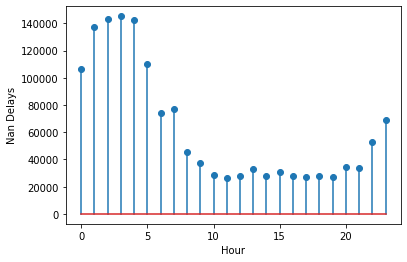

In [43]:
plt.figure()
plt.bar(range(24), hour_nan['MEDIAN_ARR_DELAY'])
plt.xlabel('Hour')
plt.ylabel('Nan Delays')

In [27]:
v = 0

signal = df_signal['MEDIAN_DEP_DELAY'].fillna(v).values.reshape([dates.shape[0], hours.shape[0], od_pairs.shape[0]])
signal = np.swapaxes(signal, 1, 2)

In [ ]:
# One OD pair, the whole day, 10 days
for i in range(10):
    plt.figure(figsize=[14, 2])
    plt.plot(signal[i, 0])
    plt.tight_layout()
    plt.show()

# 6) Creating the label

In [31]:
th = 60
h = 2

df_signal_shifted = df_signal['MEDIAN_DEP_DELAY'].fillna(v).shift(-h*od_pairs.shape[0]).fillna(-1)
labels_regression = df_signal_shifted.values.reshape([dates.shape[0], hours.shape[0], od_pairs.shape[0]])
labels_classification = 1*(labels_regression >= h)

labels_regression = np.swapaxes(labels_regression, 1, 2)
labels_classification = np.swapaxes(labels_classification, 1, 2)

df_signal['y_reg'] = df_signal_shifted
df_signal['y_clas'] = 1*(df_signal_shifted.values >= th)

## 7) Saving data

In [36]:
df_signal.head()

,FL_DATE,HOUR,OD_PAIR,DEP_DELAY,ARR_DELAY,MEDIAN_ARR_DELAY,MEDIAN_DEP_DELAY,DAY,DAY_OF_WEEK,QUARTER,YEAR,SEASON
0,2018-01-01,0,ANC_SEA,"[12.0, -10.0]",[],NaN,1.0,1,0,1,2018,2
1,2018-01-01,0,ATL_AUS,NaN,NaN,NaN,NaN,1,0,1,2018,2
2,2018-01-01,0,ATL_BNA,NaN,NaN,NaN,NaN,1,0,1,2018,2
3,2018-01-01,0,ATL_BOS,"[14.0, -4.0]","[-9.0, -15.0, 86.0]",-9.0,5.0,1,0,1,2018,2
4,2018-01-01,0,ATL_BWI,NaN,NaN,NaN,NaN,1,0,1,2018,2


In [35]:
df_signal.memory_usage().sum()/(1024*1024)

347.19140625

In [37]:
df_signal.shape

(3500544, 12)

In [39]:
df_signal.to_csv(OUT_PATH + 'signal.csv', sep='|', index=False, index_label=False)

In [40]:
df_com_nodes.drop(columns=['DEP_DELAY', 'ARR_DELAY']).to_csv(OUT_PATH + 'airport_delays.csv', sep='|', index=False, index_label=False)

In [41]:
with open(OUT_PATH + 'most_delayed_pairs.txt', 'w') as f:
    f.write('\n'.join(most_delayed_pairs))